# Experimentacion

In [15]:
import numpy as np
import pandas as pd
import seaborn as sns
import subprocess
import matplotlib.pyplot as plt
import glob, os
import math
import random
from subprocess import Popen, PIPE
import tqdm

In [16]:
NS_PER_SECOND = 1000000000

def getTime(s, ns):
    if (s > 0 and ns < 0):
        ns += NS_PER_SECOND
        s=s-1
    elif (s < 0 and ns > 0):
        ns -= NS_PER_SECOND
        s=s+1

    ms = ns / 1000000
    ms += s * 1000
    return ms

In [17]:
executablePath = './../codigo/build/ContarPalabras'
os.chdir("./")
print(executablePath)

datasets = os.listdir("./data/")
print(datasets)
datasets = datasets[1:]
print(datasets)

./../codigo/build/ContarPalabras
['incremental', 'normal.txt', 'uniforme.txt']
['normal.txt', 'uniforme.txt']


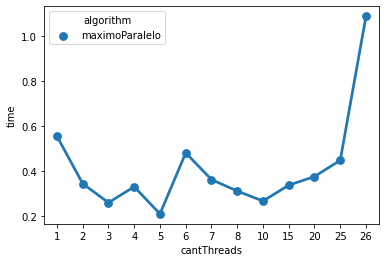

In [22]:
threads = [1,2,3,4,5,6,7,8,10,15,20,25,26]
columns = ['cantThreads', 'sec', 'ns', 'algorithm']

df = pd.DataFrame(columns = columns)
dataframes = []

for repeat in range(10):
    #create output file
    result = './results/uniforme.csv'
    outputFile = open(result, 'w+')
    outputFile.write("cantThreads,sec,ns,algorithm\n")
    
    args = "./data/uniforme.txt"
    
    for cantThreads in threads:
        command = executablePath + " %s %s %s" % (cantThreads, cantThreads, args)
        p = subprocess.Popen(command, shell=True, stdout=subprocess.PIPE)
        p.wait()
        
        output=p.stdout.read().decode("utf-8")
        outputFile.write(output)
    
    outputFile.close()
    
    df = pd.read_csv(result, header=[0])
    dataframes.append(df)
    
dfExp = pd.concat(dataframes)
#print(dfExp)
dfExp['time'] = dfExp.apply(lambda row : getTime(row['sec'],row['ns']), axis = 1)
result = dfExp.groupby(['cantThreads', 'algorithm']).mean().reset_index()
#print(result)
ax= sns.pointplot(data=result[(result.algorithm == 'maximoParalelo')], x='cantThreads', y='time',hue="algorithm", ci=None)

In [ ]:
threads = [1,2,3,4,5,6,7,8]
columns = ['cantThreads', 'sec', 'ns', 'algorithm']

df = pd.DataFrame(columns = columns)
dataframes = []
datasetsDir="./data/incremental/"

for repeat in range(5):
    for dataset in os.listdir(datasetsDir):
        #create output file
        result = './results/uniformeMultiplesArchivos.csv'
        outputFile = open(result, 'w+')
        outputFile.write("cantThreads,sec,ns,algorithm\n")

        args = ""
        for file in os.listdir(datasetsDir + dataset):
                args += " " + datasetsDir + dataset + "/" + file

        #print (args)
        for cantThreads in threads:
            command = executablePath + " %s %s %s" % (cantThreads, cantThreads, args)
            p = subprocess.Popen(command, shell=True, stdout=subprocess.PIPE)
            p.wait()

            output=p.stdout.read().decode("utf-8")
            outputFile.write(output)

        outputFile.close()

        df = pd.read_csv(result, header=[0])
        dataframes.append(df)
    
dfExp = pd.concat(dataframes)
print(dfExp)
dfExp['time'] = dfExp.apply(lambda row : getTime(row['sec'],row['ns']), axis = 1)
result = dfExp.groupby(['cantThreads', 'algorithm']).mean().reset_index()
print(result)
ax= sns.pointplot(data=result[(result.algorithm == 'cargarMultiplesArchivos')], x='cantThreads', y='time',hue="algorithm", ci=None)